 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the LICENSE file
 in the root directory of this source tree.

# Outlook

In this notebook, using BBRL, we code a version of the DQN algorithm with a
replay buffer and a target network, using the AutoReset approach.

To understand this code, you need to know more about
[the BBRL interaction model](https://github.com/osigaud/bbrl/blob/master/docs/overview.md)
Then you should run [a didactical example](https://github.com/osigaud/bbrl/blob/master/docs/notebooks/03-multi_env_autoreset.student.ipynb)
to see how agents interact in BBRL when autoreset=True.

The DQN algorithm is explained in [this
video](https://www.youtube.com/watch?v=CXwvOMJujZk) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/dqn.pdf).

In this notebook, we will modify the previous notebook:

- to use a replay buffer and an environment that resets
- to use a target network for $Q$
- to use a better estimation for the maximum (Double-DQN)

In [45]:
# # Prepare the environment

try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
import copy
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, copy_parameters
from bbrl_utils.notebook import setup_tensorboard
from omegaconf import OmegaConf

[easypip] Installing bbrl_utils


# Learning environment

## Configuration

The learning environment is controlled by a configuration providing a few
important things as described in the example below. This configuration can
hold as many extra information as you need, the example below is the minimal
one.

```python
params = {
    # This defines the a path for logs and saved models
    "base_dir": "${gym_env.env_name}/myalgo_${current_time:}",

    # The Gymnasium environment
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },

    # Algorithm
    "algorithm": {
        # Seed used for the random number generator
        "seed": 1023,

        # Number of parallel training environments
        "n_envs": 8,

        # Number of transitions to collect at each epoch for an environment.
        # This number has to be multiplied by n_envs to get the number of new transitions
        # collected at each epoch.
        "n_steps": 100,

        # Number of transitions before starting to train
        "learning_starts": 10_000,
                
        # Minimum number of steps between two evaluations
        "eval_interval": 500,
        
        # Number of parallel evaluation environments
        "nb_evals": 10,

        # Number of epochs (loops)
        "max_epochs": 40000,
    },
}

# Creates the configuration object, i.e. cfg.algorithm.nb_evals is 10
cfg = OmegaConf.create(params)
```

## The RL algorithm

In this notebook, the RL algorithm is based on `EpochBasedAlgo`, that defines
the algorithm environment when using episodes. To use such environment, we
just need to subclass `EpochBasedAlgo` and to define two things, namely the
`train_policy` and the `eval_policy`. Both are BBRL agents that, given the
environment state, select the action to perform.

```py
  class MyAlgo(EpochBasedAlgo):
      def __init__(self, cfg):
          super().__init__(cfg)

          # Define the train and evaluation policies
          # (the agents compute the workspace `action` variable)
          self.train_policy = MyPolicyAgent(...)
          self.eval_policy = MyEvalAgent(...)

algo = MyAlgo(cfg)
```

The `EpochBasedAlgo` defines useful objects:

- `algo.cfg` is the configuration
- `algo.nb_steps` (integer) is the number of steps since the training began
- `algo.logger` is a logger that can be used to collect statistics during training:
    - `algo.logger.add_log("critic_loss", critic_loss, algo.nb_steps)` registers the `critic_loss` value on tensorboard
- `algo.evaluate()` evaluates the current `eval_policy` if needed, and keeps the
agent if it was the best so far (average cumulated reward);
- `algo.visualize_best()` runs the best agent on one episode, and displays the video

## Definition of agents

In the following, we define three agents:
1. `DiscreteQAgent` the computes the Q-values
2. `ArgmaxActionSelector` that selects the action that maximizes the Q-value
3. `EGreedyActionSelector` which behaves randomly with probability $\epsilon$,
   and otherwise behaves as `ArgmaxActionSelector`

Note that contrarily to previous notebooks, we work here with $n$ environments
in parallel (first dimension of each tensor)

### The critic agent

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only
algorithm. Thus we just need a Critic agent (which will also be used to output
actions) and an Environment agent. We reuse the `DiscreteQAgent` class that we
have already explained in the previous notebook.

In [46]:
class DiscreteQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        q_values = self.model(obs)
        self.set((f"{self.prefix}q_values", t), q_values)

### Creating an actor agent

In [47]:
class ArgmaxActionSelector(Agent):
    """BBRL agent that selects the best action based on Q(s,a)"""

    def forward(self, t: int, **kwargs):
        q_values = self.get(("q_values", t))
        action = q_values.argmax(-1)
        self.set(("action", t), action)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence.
Here we will use the simple $\epsilon$-greedy exploration method. The method
is implemented as an agent which chooses an action based on the Q-values.

In [48]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t: int, **kwargs):
        # Retrieves the q values
        # (matrix nb. of episodes x nb. of actions)
        q_values: torch.Tensor = self.get(("q_values", t))
        size, nb_actions = q_values.shape

        # Flag
        is_random = torch.rand(size) > self.epsilon
        
        # Actions (random / argmax)
        random_action = torch.randint(nb_actions, size=(size,))
        max_action = q_values.argmax(-1)

        # Choose the action based on the is_random flag
        action = torch.where(is_random, random_action, max_action)

        # Sets the action at time t
        self.set(("action", t), action)

## Main training loop

Note that everything about the shared workspace between all the agents is
completely hidden under the hood. This results in a gain of productivity, at
the expense of having to dig into the BBRL code if you want to understand the
details, change the multiprocessing model, etc.

### Agent execution

This is the tricky part with BBRL, the one we need to understand in detail.
The difficulty lies in the copy of the last step and the way to deal with the
n_steps return.

The call to `train_agent(workspace, t=1, n_steps=cfg.algorithm.n_timesteps -
1, stochastic=True)` makes the agent run a number of steps in the workspace.
In practice, it calls the
[`__call__(...)`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/agents/agent.py#L59)
function which makes a forward pass of the agent network using the workspace
data and updates the workspace accordingly.

Now, if we start at the first epoch (`epoch=0`), we start from the first step
(`t=0`). But when subsequently we perform the next epochs (`epoch>0`), we must
not forget to cover the transition at the border between the previous epoch
and the current epoch. To avoid this risk, we copy the information from the
last time step of the previous epoch into the first time step of the next
epoch.

Note that we `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`
lines. `optimizer.zero_grad()` is necessary to cancel all the gradients
computed at the previous iterations

In [49]:
class DQN(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()

        # Get the two agents (critic and target critic)
        critic = DiscreteQAgent(
            obs_size, cfg.algorithm.architecture.hidden_size, act_size
        )
        target_critic = copy.deepcopy(critic).with_prefix("target/")

        # Builds the train agent that will produce transitions
        explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
        self.train_policy = Agents(critic, explorer)

        self.eval_policy = Agents(critic, ArgmaxActionSelector())

        # Creates two temporal agents just for "replaying" some parts
        # of the transition buffer
        self.t_q_agent = TemporalAgent(critic)
        self.t_target_q_agent = TemporalAgent(target_critic)

        # Get an agent that is executed on a complete workspace
        self.optimizer = setup_optimizer(cfg.optimizer, self.t_q_agent)

        self.last_critic_update_step = 0

### Compute critic loss

Detailed explanations of the function to compute the critic loss when using
`autoreset=False` are given in [this
notebook](http://master-dac.isir.upmc.fr/rld/rl/03-1-dqn-introduction.student.ipynb).
The case where we use `autoreset=True` is very similar, but we need to
specify that we use the first part of the Q-values (`q_values[0]`) for
representing $Q(s_t,a_t)$ and the second part (`q_values[1]`) for representing
$Q(s_{t+1},a)$, as these values are stored into a transition buffer.

In [50]:
def dqn_compute_critic_loss(
    cfg, reward, must_bootstrap, q_values, target_q_values, action
):
    """Compute the critic loss

    :param reward: The reward $r_t$ (shape 2 x B)
    :param must_bootstrap: The must bootstrap flag at $t+1$ (shape 2 x B)
    :param q_values: The Q-values (shape 2 x B x A)
    :param target_q_values: The target Q-values (shape 2 x B x A)
    :param action: The chosen actions (shape 2 x B)
    :return: _description_
    """

    # Implement the DQN loss

    # Adapt from the previous notebook and adapt to our case (target Q network)
    # Don't forget that we deal with transitions (and not episodes)

    max_qvalues = target_q_values[1].max(-1).values.detach()
    target = (reward[1] + cfg.algorithm.discount_factor * max_qvalues * must_bootstrap[1].int())

    act = action[0].unsqueeze(-1)
    qvals = torch.gather(q_values[0], dim=1, index=act).squeeze(-1)


    # Compute critic loss (no need to use must_bootstrap here since we are dealing with "full" transitions)
    mse = nn.MSELoss()
    critic_loss = mse(target, qvals)

    return critic_loss


## Main training loop

In [51]:
def run(dqn: DQN, compute_critic_loss):
    for rb in dqn.iter_replay_buffers():
        for _ in range(dqn.cfg.algorithm.n_updates):
            rb_workspace = rb.get_shuffled(dqn.cfg.algorithm.batch_size)

            # The q agent needs to be executed on the rb_workspace workspace
            dqn.t_q_agent(rb_workspace, t=0, n_steps=2, choose_action=False)
            with torch.no_grad():
                dqn.t_target_q_agent(rb_workspace, t=0, n_steps=2, stochastic=True)

            q_values, terminated, reward, action, target_q_values = rb_workspace[
                "q_values", "env/terminated", "env/reward", "action", "target/q_values"
            ]

            # Determines whether values of the critic should be propagated
            must_bootstrap = ~terminated

            # Compute critic loss
            critic_loss = compute_critic_loss(
                dqn.cfg, reward, must_bootstrap, q_values, target_q_values, action
            )
            # Store the loss for tensorboard display
            dqn.logger.add_log("critic_loss", critic_loss, dqn.nb_steps)
            dqn.logger.add_log("q_values/min", q_values.max(-1).values.min(), dqn.nb_steps)
            dqn.logger.add_log("q_values/max", q_values.max(-1).values.max(), dqn.nb_steps)
            dqn.logger.add_log("q_values/mean", q_values.max(-1).values.mean(), dqn.nb_steps)

            dqn.optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                dqn.t_q_agent.parameters(), dqn.cfg.algorithm.max_grad_norm
            )
            dqn.optimizer.step()

            # Update target
            if (
                dqn.nb_steps - dqn.last_critic_update_step
                > dqn.cfg.algorithm.target_critic_update
            ):
                dqn.last_critic_update_step = dqn.nb_steps
                copy_parameters(dqn.t_q_agent, dqn.t_target_q_agent)

            dqn.evaluate()

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

### Launching tensorboard to visualize the results

In [52]:
setup_tensorboard("./outputs/tblogs")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 29280), started 1:40:28 ago. (Use '!kill 29280' to kill it.)

In [53]:
params = {
    "base_dir": "${gym_env.env_name}/dqn-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    "save_best": False,
    "algorithm": {
        "seed": 4,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 8,
        "n_steps": 32,
        "n_updates": 32,
        "eval_interval": 2000,
        "learning_starts": 5000,
        "nb_evals": 10,
        "buffer_size": 100_000,
        "batch_size": 256,
        "target_critic_update": 1_000,
        "max_epochs": 3_000,
        "discount_factor": 0.99,
        "architecture": {"hidden_size": [256, 256]},
    },
    "gym_env": {
        "env_name": "CartPole-v1",
    },
    "optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

dqn = DQN(OmegaConf.create(params))
run(dqn, dqn_compute_critic_loss)
dqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

Video of best agent recorded in outputs/CartPole-v1/dqn-S4_20241004-112129/best_agent.mp4
Moviepy - Building video /Users/saad/M2/IAR/outputs/CartPole-v1/dqn-S4_20241004-112129/best_agent.mp4.
Moviepy - Writing video /Users/saad/M2/IAR/outputs/CartPole-v1/dqn-S4_20241004-112129/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /Users/saad/M2/IAR/outputs/CartPole-v1/dqn-S4_20241004-112129/best_agent.mp4


## Coding Exercise: Double DQN (DDQN)

In DQN, the same network is responsible for selecting and estimating the best
next action (in the TD-target) and that may lead to over-estimation: the
action which q-value is over-estimated will be chosen more often. As a result,
training is slower.

To reduce over-estimation, double q-learning (and then DDQN) was proposed. It
decouples the action selection from the value estimation.

Concretely, in DQN, the target value in the critic loss (used to update the Q
critic) for a sample at time $t$ is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1},
a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `target_q_agent` with parameters
$\mathbb{\theta}_{target}$ is used for both action selection and estimation,
and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a;
\mathbb{\theta}_{target}\right)$$

Instead, DDQN uses the online critic `q_agent` with parameters
$\mathbb{\theta}_{online}$ to select the action, whereas it uses the target
network `target_q_agent` to estimate the associated Q-values:

$$Y^{DDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1},
a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$

The goal in this exercise is for you to write the update method for `DDQN`.

In [54]:
def ddqn_compute_critic_loss(
    cfg, reward, must_bootstrap, q_values, target_q_values, action
):
    """Compute the critic loss

    :param reward: The reward $r_t$ (shape 2 x B)
    :param must_bootstrap: The must bootstrap flag at $t+1$ (shape 2 x B)
    :param q_values: The Q-values (shape 2 x B x A)
    :param target_q_values: The target Q-values (shape 2 x B x A)
    :param action: The chosen actions (shape 2 x B)
    :return: the loss (a scalar)
    """

    # Implement the double DQN loss

    # Select the best action using the online Q-values
    best_actions = q_values[1].argmax(-1)

    # Use the target Q-values to estimate the value of the best action
    max_qvalues = target_q_values[1].gather(-1, best_actions.unsqueeze(-1)).squeeze(-1).detach()

    # Compute the target value
    target = reward[1] + cfg.algorithm.discount_factor * max_qvalues * must_bootstrap[1].int()

    # Get the Q-values for the chosen actions
    act = action[0].unsqueeze(-1)
    qvals = torch.gather(q_values[0], dim=1, index=act).squeeze(-1)

    # Compute critic loss
    mse = nn.MSELoss()
    critic_loss = mse(target, qvals)
    return critic_loss

In [55]:
params = {
    "base_dir": "${gym_env.env_name}/double-dqn-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    "save_best": False,
    "algorithm": {
        "seed": 3,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 8,
        "n_steps": 32,
        "n_updates": 32,
        "eval_interval": 2_000,
        "learning_starts": 5_000,
        "nb_evals": 10,
        "buffer_size": 100_000,
        "batch_size": 256,
        "target_critic_update": 1000,
        "max_epochs": 3_000,
        "discount_factor": 0.99,
        "architecture": {"hidden_size": [128, 128]},
    },
    "gym_env": {
        "env_name": "CartPole-v1",
    },
    "optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

ddqn = DQN(OmegaConf.create(params))
run(ddqn, ddqn_compute_critic_loss)
ddqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

Video of best agent recorded in outputs/CartPole-v1/double-dqn-S3_20241004-112732/best_agent.mp4
Moviepy - Building video /Users/saad/M2/IAR/outputs/CartPole-v1/double-dqn-S3_20241004-112732/best_agent.mp4.
Moviepy - Writing video /Users/saad/M2/IAR/outputs/CartPole-v1/double-dqn-S3_20241004-112732/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /Users/saad/M2/IAR/outputs/CartPole-v1/double-dqn-S3_20241004-112732/best_agent.mp4


  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,



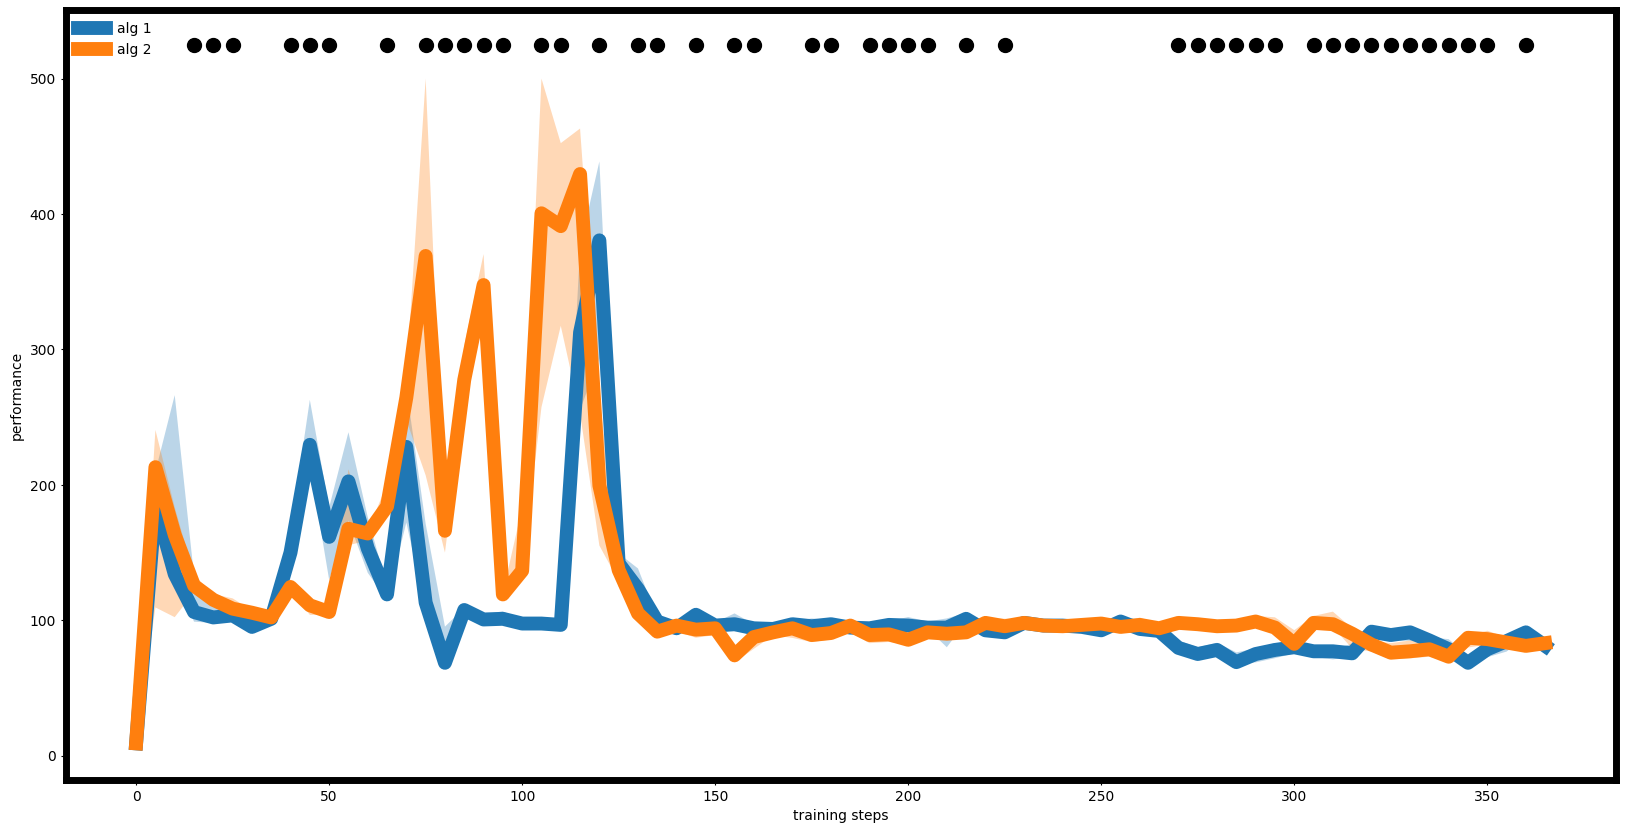

: 

In [56]:
from bbrl.stats import WelchTTest

WelchTTest().plot(
    torch.stack(dqn.eval_rewards), torch.stack(ddqn.eval_rewards), save=False
)